
# 04. Beta Diversity 

Author: Marc Kesselring


In this Jupyter Notebook the beta diversity of the samples is analyzed.

**Exercise overview:**<br>
[1. Setup](#setup)<br>
[2. Visual Inspection](#inspection)<br>
[3. Statistical Analysis](#stat)<br>
[4. Beta correlation](#corr)<br>

<a id='setup'></a>

## 1. Setup

In [31]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import biom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from skbio.stats.ordination import pcoa
%matplotlib inline

In [2]:
# assigning variables throughout the notebook
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

<a id='inspection'></a>

## 2. Visual Inspection

In [4]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/weighted_unifrac_emperor.qzv")

<visualization: Visualization uuid: cbbe3e41-299a-41e3-a6f6-8f5bc217a8fe>

In [5]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: cbffe7f4-4a6d-4357-a60e-f85724dafb47>

<a id='stat'></a>

## 3. Statistical Analysis

In [11]:
#Fill data missing in Recovery_Days with 0
md = pd.read_csv(f"{data_dir}/metadata.tsv", sep='\t')
md = md.fillna(0)
md.to_csv(f"{data_dir}/metadata_fillna.tsv", sep='\t', index=False)

##### Using qiime diversity adonis to test for statistical significances in beta diversity according to following R-formula Cohort_Number*Stool_Consistency*Patient_Sex*Sample_Day*Recovery_Day

In [4]:
! qiime diversity adonis \
--i-distance-matrix $data_dir/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza \
--m-metadata-file $data_dir/metadata_fillna.tsv \
--p-formula Cohort_Number*Stool_Consistency*Patient_Sex*Sample_Day*Recovery_Day \
--o-visualization $data_dir/core-metrics-results-bt/beta-diversity/weighted_unifrac_adonis.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-diversity/weighted_unifrac_adonis.qzv


In [5]:
! qiime diversity adonis \
--i-distance-matrix $data_dir/core-metrics-results-bt/bray_curtis_distance_matrix.qza \
--m-metadata-file $data_dir/metadata_fillna.tsv \
--p-formula Cohort_Number*Stool_Consistency*Patient_Sex*Sample_Day*Recovery_Day \
--o-visualization $data_dir/core-metrics-results-bt/beta-diversity/bray_curtis_adonis.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-diversity/bray_curtis_adonis.qzv


### Visualizations of the generated qzv files and downloading the tsv files to use for further analysis

In [6]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-diversity/weighted_unifrac_adonis.qzv")

<visualization: Visualization uuid: 886ff7dc-3695-4c4c-8683-6c0d0c56ef75>

In [8]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-diversity/bray_curtis_adonis.qzv")

<visualization: Visualization uuid: e2148b82-01a2-4d5c-a592-bc6560c3f1c7>

### Adjustments for multiple testing using the Bonferroni correction using pandas after uploading the tsv files into this environment

In [10]:
# Load adonis result
df_unifrac = pd.read_csv(f"{data_dir}/core-metrics-results-bt/beta-diversity/adonis_weighted_unifrac.tsv", sep="\t")

# Add a Bonferroni-adjusted p-value column
num_tests = len(df_unifrac)  # Number of tests performed
df_unifrac['p_value_bonferroni'] = df_unifrac['Pr(>F)'] * num_tests

# Ensure adjusted p-values do not exceed 1
df_unifrac['p_value_bonferroni'] = df_unifrac['p_value_bonferroni'].clip(upper=1)

# Save the adjusted results to a new file
df_unifrac.to_csv(f"{data_dir}/core-metrics-results-bt/beta-diversity/adonis_weighted_unifrac_bonferroni.tsv", sep='\t', index=False)

print(df_unifrac[df_unifrac['p_value_bonferroni']<0.05])

               Df  SumsOfSqs   MeanSqs    F.Model        R2  Pr(>F)  \
Cohort_Number   1   5.262276  5.262276  14.615373  0.127197   0.001   

               p_value_bonferroni  
Cohort_Number               0.025  


In [11]:
# Load adonis result
df_bray_curtis = pd.read_csv(f"{data_dir}/core-metrics-results-bt/beta-diversity/adonis_bray_curtis.tsv", sep="\t")

# Add a Bonferroni-adjusted p-value column
num_tests = len(df_bray_curtis)  # Number of tests performed
df_bray_curtis['p_value_bonferroni'] = df_bray_curtis['Pr(>F)'] * num_tests

# Ensure adjusted p-values do not exceed 1
df_bray_curtis['p_value_bonferroni'] = df_bray_curtis['p_value_bonferroni'].clip(upper=1)

# Save the adjusted results to a new file
df_bray_curtis.to_csv(f"{data_dir}/core-metrics-results-bt/beta-diversity/adonis_bray_curtis_bonferroni.tsv", sep='\t', index=False)

print(df_bray_curtis[df_bray_curtis['p_value_bonferroni']<0.05])

               Df  SumsOfSqs   MeanSqs   F.Model        R2  Pr(>F)  \
Cohort_Number   1   1.409494  1.409494  3.128293  0.033285   0.001   

               p_value_bonferroni  
Cohort_Number               0.025  


### pairwise Permanova testing column Cohort_Number to obtain Group significance plots

In [13]:
# Map Cohort_Number data into categorical data
metadata = pd.read_csv(f"{data_dir}/metadata.tsv", sep='\t')
metadata['Cohort_Number_Bin'] = metadata['Cohort_Number'].map({1: 'Abduction', 2: 'Recovery'})
metadata.to_csv(f"{data_dir}/metadata_binned.tsv", sep='\t', index=False)

##### Weighted unifrac

In [14]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_binned.tsv \
    --m-metadata-column Cohort_Number_Bin \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results-bt/beta-correlation/weighted_unifrac-Cohort-number-significance.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-correlation/weighted_unifrac-Cohort-number-significance.qzv


In [15]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-correlation/weighted_unifrac-Cohort-number-significance.qzv")

<visualization: Visualization uuid: 2d02e4ba-a5ec-4ce3-b773-7d1a9ab1ded6>

##### Bray Curtis

In [16]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results-bt/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata_binned.tsv \
    --m-metadata-column Cohort_Number_Bin \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results-bt/beta-correlation/bray_curtis-Cohort-number-significance.qzv

Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-correlation/bray_curtis-Cohort-number-significance.qzv


In [17]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-correlation/bray_curtis-Cohort-number-significance.qzv")

<visualization: Visualization uuid: e799ad4e-0e43-4b3a-8cb8-d3b8b559c780>

<a id='corr'></a>

## 4. Beta correlation

### Testing column Cohort_Number for beta correlation

In [18]:
! qiime diversity beta-correlation \
    --i-distance-matrix $data_dir/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column Cohort_Number \
    --p-intersect-ids \
    --o-metadata-distance-matrix $data_dir/core-metrics-results-bt/beta-correlation/weighted_unifrac_spearman.qza \
    --o-mantel-scatter-visualization $data_dir/core-metrics-results-bt/beta-correlation/weighted_unifrac_scatter-plot.qzv

Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/beta-correlation/weighted_unifrac_spearman.qza
Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-correlation/weighted_unifrac_scatter-plot.qzv


In [19]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-correlation/weighted_unifrac_scatter-plot.qzv")

<visualization: Visualization uuid: 371fb82e-c728-4736-98f3-5741eefee64d>

In [20]:
! qiime diversity beta-correlation \
    --i-distance-matrix $data_dir/core-metrics-results-bt/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column Cohort_Number \
    --p-intersect-ids \
    --o-metadata-distance-matrix $data_dir/core-metrics-results-bt/beta-correlation/bray_curtis_spearman.qza \
    --o-mantel-scatter-visualization $data_dir/core-metrics-results-bt/beta-correlation/bray_curtis_scatter-plot.qzv

Saved DistanceMatrix to: ../data/processed/core-metrics-results-bt/beta-correlation/bray_curtis_spearman.qza
Saved Visualization to: ../data/processed/core-metrics-results-bt/beta-correlation/bray_curtis_scatter-plot.qzv


In [21]:
Visualization.load(f"{data_dir}/core-metrics-results-bt/beta-correlation/bray_curtis_scatter-plot.qzv")

<visualization: Visualization uuid: 18166f36-6842-4076-b976-d2adf998ab8b>

##### Weak positive correlation for column Cohort_Number

### Visualize weighted unifrac distance matrix for cluster analysis

In [25]:
! qiime tools export \
  --input-path $data_dir/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza \
  --output-path $data_dir/core-metrics-results-bt/weighted_unifrac_exported_distance_matrix

Exported ../data/processed/core-metrics-results-bt/weighted_unifrac_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory ../data/processed/core-metrics-results-bt/weighted_unifrac_exported_distance_matrix


In [28]:
cluster = pd.read_csv(f"{data_dir}/core-metrics-results-bt/weighted_unifrac_exported_distance_matrix/distance-matrix.tsv", sep="\t", index_col=0)
cluster

,EG0024,EG0031,EG0039,EG0055,EG0057,EG0070,EG0088,EG0101,EG0118,EG0136,...,EG2392,EG2419,EG2435,EG2490,EG2559,EG2580,EG2591,EG2608,EG2638,EG2659
EG0024,0.000000,1.127390,1.081674,1.319838,1.483432,0.533328,1.401837,1.215385,1.442296,0.565520,...,0.931803,0.507066,0.996397,0.794942,1.356327,1.170884,0.757401,1.087176,1.328130,1.370918
EG0031,1.127390,0.000000,1.200156,1.514981,1.663183,0.996829,1.601194,1.059597,1.635188,0.967594,...,1.249840,0.861903,1.180261,1.179882,1.349607,1.351806,1.100723,1.323395,1.434430,1.578066
EG0039,1.081674,1.200156,0.000000,0.654672,0.693817,0.960235,0.819727,0.478843,0.868100,0.852139,...,0.485492,0.797128,0.622236,0.922363,0.622021,0.541948,0.863001,0.802405,1.344612,0.708338
EG0055,1.319838,1.514981,0.654672,0.000000,0.317155,1.246121,0.368942,0.694269,0.390615,1.158980,...,0.723617,1.091826,1.046003,1.180003,0.740973,0.656958,1.153567,0.973655,1.505115,0.155755
EG0057,1.483432,1.663183,0.693817,0.317155,0.000000,1.413153,0.449063,0.831047,0.456343,1.327686,...,0.798922,1.258700,1.136324,1.346182,0.898632,0.797298,1.321769,1.142450,1.667484,0.368833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EG2580,1.170884,1.351806,0.541948,0.656958,0.797298,1.093209,0.600825,0.410647,0.760830,0.969782,...,0.549857,0.906993,0.738305,1.001051,0.340324,0.000000,0.939587,0.868087,1.399010,0.670556
EG2591,0.757401,1.100723,0.863001,1.153567,1.321769,0.564239,1.201589,1.008071,1.281104,0.426520,...,0.783733,0.456393,0.730369,0.519184,1.130786,0.939587,0.000000,0.707725,0.909936,1.195209
EG2608,1.087176,1.323395,0.802405,0.973655,1.142450,1.038141,1.099622,0.943335,1.140530,0.910130,...,0.763029,0.869629,0.840373,0.770440,1.066138,0.868087,0.707725,0.000000,0.814140,1.026066
EG2638,1.328130,1.434430,1.344612,1.505115,1.667484,1.176799,1.587517,1.426598,1.625933,1.117910,...,1.270912,1.089224,1.187073,0.722023,1.548907,1.399010,0.909936,0.814140,0.000000,1.570002


In [33]:
cluster_pcoa = pcoa(cluster)
cluster_coordinates = cluster_pcoa.samples
cluster_coordinates

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94
0,-0.553182,0.045509,-0.347423,0.047783,0.006516,0.225795,0.255852,-0.294292,-0.036904,-0.068100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.570544,0.308574,0.455249,0.667092,0.013150,-0.079201,-0.060499,-0.184789,0.036624,0.019868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.206745,0.166945,0.132789,-0.020665,-0.082996,0.019774,0.228563,0.185352,-0.063685,0.104787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.655565,0.026128,-0.130415,0.118041,0.023889,-0.082259,0.070301,0.065003,0.029665,-0.050441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.812617,0.084057,-0.142095,0.131855,-0.058525,-0.019650,0.122936,0.199948,-0.058690,-0.076698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.324092,0.139272,0.088858,-0.258465,0.130502,-0.054689,-0.021380,-0.041390,0.077127,0.086707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,-0.400782,-0.188921,0.008062,-0.093072,-0.005501,0.011851,-0.029192,0.099179,0.015721,0.056959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,-0.006316,-0.502886,0.258905,-0.056181,0.010926,0.108942,0.128351,0.137326,-0.038185,-0.047708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,-0.395174,-0.858993,0.244940,-0.024219,-0.178235,-0.427381,0.019834,-0.086218,-0.245607,0.034698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
md = pd.read_csv(f"{data_dir}/metadata_binned.tsv", sep="\t")
md_cluster = md.merge(cluster,  how='inner', left_on='sample-id', right_index=True)
md_cluster['sample-id'] = md_cluster['sample-id'].str.replace(r'EG', '', regex=True).astype(int)
md_sort = md_cluster.sort_values('sample-id', axis=0, ascending=True, inplace=False, kind='quicksort', ignore_index=True)
md_sort_merged = md_sort.merge(cluster_coordinates, how='inner', on=md_sort.index)

/tmp/ipykernel_370/3691472638.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({cluster_pcoa.proportion_explained[0]:.2%} variance)")
/tmp/ipykernel_370/3691472638.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({cluster_pcoa.proportion_explained[1]:.2%} variance)")


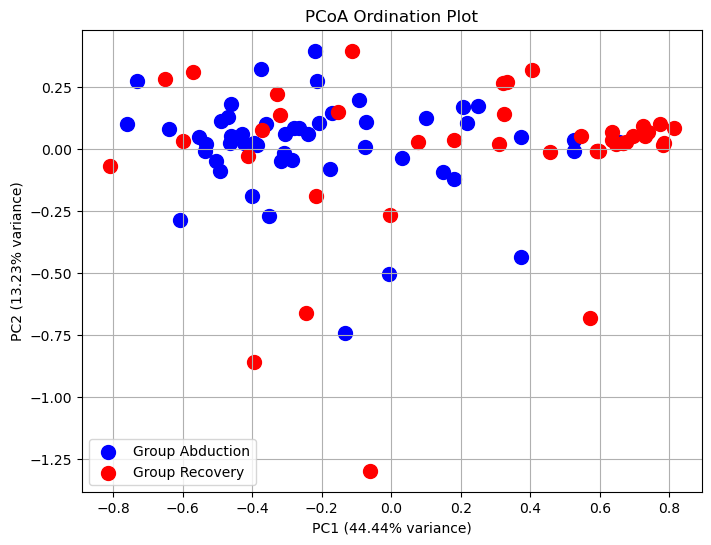

In [111]:
plt.figure(figsize=(8, 6))
for group, color in zip(['Abduction', 'Recovery'], ['blue', 'red']):
    subset = md_sort_merged[md_sort_merged['Cohort_Number_Bin'] == group]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Group {group}', color=color, s=100)

plt.xlabel(f"PC1 ({cluster_pcoa.proportion_explained[0]:.2%} variance)")
plt.ylabel(f"PC2 ({cluster_pcoa.proportion_explained[1]:.2%} variance)")
plt.title("PCoA Ordination Plot")
plt.legend()
plt.grid(True)
plt.show()